- 참고 
1. https://www.youtube.com/watch?v=ACmuBbuXn20

2. https://blogofth-lee.tistory.com/265

3. https://www.kaggle.com/willzy/vgg16-with-cifar10

- Torch library 정의
- cifar10 데이터 불러와서 training_set과 test_set으로 분리
- cifar10 데이터 내의 classes들 정의


In [1]:
import torch
from torch import nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import random
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pretrained_model_path = './data/pretrained.model.pt'
save_model_path = './data/'
save_result_path = './data/results'
validation_ratio = 0.1

In [3]:


training_data = datasets.CIFAR10(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

validation_data = datasets.CIFAR10(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.CIFAR10(
    root = "data",
    train=False,
    download = True,
    transform = ToTensor()
)

num_train = len(training_data)
print(num_train)
indices = list(range(num_train))
split = int(np.floor(validation_ratio * num_train))

np.random.seed(12)
np.random.shuffle(indices)

train_idx , valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(training_data,
                                          batch_size = 32,
                                          sampler=train_sampler,
                                          num_workers=0)

validloader = torch.utils.data.DataLoader(validation_data,
                                          batch_size= 32, sampler=valid_sampler,
                                          num_workers=0)

testloader = torch.utils.data.DataLoader(test_data,
                                          batch_size = 4,
                                          shuffle = False,
                                          num_workers=0)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')




Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified
50000


- cpu로 연산할 지 gpu로 연산할 지 설정

- 몇 개의 testset 표시

In [4]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images.size()

torch.Size([4, 3, 32, 32])

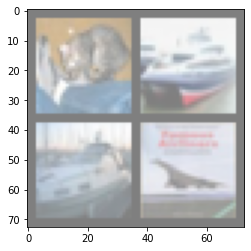

  cat  ship  ship plane


In [5]:
import matplotlib.pyplot as plt

%matplotlib inline

def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images, nrow=2, padding=3))

print(' '.join('%5s'%classes[labels[j]] for j in range(4)))

- 13개의 cnn 필터 + fully connected layer 3층
- 3 x 3 filter 2회와 5 x 5 filter 1회의 결과가 같음(동일한 사이즈의 특성맵 산출) 따라서 3 x 3 filter를 2회 하는게 더 나음. 
(Hyperparameter 18개 vs 25개)

In [6]:
VGG_list = [32, 32, 'M', 64, 64, 
            128, 128, 128, 
            'M', 256, 256, 256, 
            512, 512, 512, 'M'] 
# For cifar 10, modify the size of cnn.
class VGGnet(nn.Module):
  def __init__(self, in_channels, num_classes=10):
    super(VGGnet, self).__init__()
    self.in_channels = in_channels 
    # The order is very important.
    # Since after declare variables, we can use the variables
    self.conv_layers = self.create_cnn(VGG_list)
   

    self.fully_connected_layer = nn.Sequential(
        nn.Linear(512*4*4, 4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096, num_classes)
    )
  def forward(self, x):
    x = self.conv_layers(x)
    x = x.reshape(x.shape[0], -1) 
    # For Linear part, we must flatten output of cnn.
    x = self.fully_connected_layer(x)
    return x
    
  def create_cnn(self, architecture):
    layers = []
    in_channels = self.in_channels

    for x in architecture:
      if type(x) == int:
        layers += [nn.Conv2d(in_channels = in_channels, out_channels = x,
                             kernel_size=(3,3), stride = (1, 1), padding = (1, 1)),
                   nn.BatchNorm2d(x),
                   nn.ReLU()]

        in_channels = x
      elif x == "M":
        layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]
    

    return nn.Sequential(*layers) # store unpacking layer list

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(12)
if device == 'cuda':
  torch.cuda.manual_seed_all(12)

In [8]:
model = VGGnet(in_channels=3, num_classes=1000).to(device)

x = torch.randn(1, 3, 32, 32).cuda()
print(model(x).shape)

torch.Size([1, 1000])


In [9]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-10)

lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)
# For every 5 steps, reduce lr by x0.9 to learn.

In [10]:
print(len(trainloader))

1407


- loss and accuracy

1. just setting layer(do not add anything)
  loss : 2.308, accuracy : 9%

2. add ReLU
  same

3. add batchnorm
  loss : 0.000114, accuracy : 67% 

4. Adam Batch size = 512 / epoch = 30 / lr = 0.001
  accuracy : 40 %

5. Batch size = 32 / epoch = 20 / Adam / lr = 0.0001
  accuracy : 82%

6. Batch size = 32 / epoch = 7 / Adam / lr = 0.0001
  accuracy : 79%

In [11]:
epochs = 7

train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

train_total_batch = len(trainloader)
valid_total_batch = len(validloader)
for epoch in range(epochs):
    
    model.train()
    

    for i, data in enumerate(trainloader, 0): # start from 0
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    lr_sche.step()
    # test with validation set if val_loader exist
    with torch.no_grad():
        model.eval()
        loss, acc = 0, 0

        for k, (X, Y) in enumerate(trainloader):
            X , Y = X.to(device), Y.to(device)
            
            val_outputs = model(X)
            val_correct_prediction = torch.argmax(val_outputs, 1) == Y
            loss += criterion(val_outputs, Y)
            acc += val_correct_prediction.float().mean()
        
        loss = loss / train_total_batch
        acc = acc / train_total_batch

        train_losses.append(loss)
        train_accs.append(acc)
        print('[Epoch %d-TRAIN] loss : %.5f, acc: %.2f'%((epoch+1), loss.item(), acc.item()))

        loss, acc = 0, 0
        for i, (X, Y) in enumerate(validloader):
            X = X.to(device)
            Y = Y.to(device)

            prediction = model(X)
            correct_prediction = torch.argmax(prediction, 1) == Y
            loss += criterion(prediction, Y)
            acc += correct_prediction.float().mean()
        loss = loss / valid_total_batch
        acc = acc / valid_total_batch

        valid_losses.append(loss)
        valid_accs.append(acc)
        print('[Epoch %d-TRAIN] loss : %.5f, acc: %.2f'%((epoch+1), loss.item(), acc.item()))
        print()

print('finished')

[Epoch 1-TRAIN] loss : 1.18700, acc: 0.58
[Epoch 1-TRAIN] loss : 1.21643, acc: 0.57

[Epoch 2-TRAIN] loss : 0.94644, acc: 0.67
[Epoch 2-TRAIN] loss : 1.03410, acc: 0.64

[Epoch 3-TRAIN] loss : 0.74077, acc: 0.74
[Epoch 3-TRAIN] loss : 0.85020, acc: 0.70

[Epoch 4-TRAIN] loss : 0.57351, acc: 0.80
[Epoch 4-TRAIN] loss : 0.74821, acc: 0.74

[Epoch 5-TRAIN] loss : 0.43354, acc: 0.85
[Epoch 5-TRAIN] loss : 0.63478, acc: 0.79

[Epoch 6-TRAIN] loss : 0.38696, acc: 0.87
[Epoch 6-TRAIN] loss : 0.64062, acc: 0.79

[Epoch 7-TRAIN] loss : 0.31426, acc: 0.89
[Epoch 7-TRAIN] loss : 0.64721, acc: 0.79

finished


In [12]:
import torchsummary
torchsummary.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
      BatchNorm2d-12           [-1, 64, 16, 16]             128
             ReLU-13           [-1, 64, 16, 16]               0
           Conv2d-14          [-1, 128,

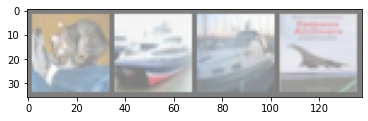

GT:    cat  ship  ship plane


In [13]:
dataiter = iter(testloader) 

images, labels = dataiter.next() 

imshow(torchvision.utils.make_grid(images)) 

print('GT: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))



In [14]:
outputs = model(images.to(device))


In [15]:
_, predicted = torch.max(outputs, 1) 
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))


Predicted:    cat  ship  ship plane


In [16]:
correct = 0 
total = 0 
with torch.no_grad(): 
  model.eval()
  for data in testloader: 
    images, labels = data 
    images = images.to(device)

    labels = labels.to(device) 
    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1) 
    total += labels.size(0) 
    correct += (predicted == labels).sum().item() 
    
  print('Acc : %d %%' % ( 100*correct / total))



Acc : 79 %


In [17]:
import matplotlib.pyplot as plt

def plot_compare(train : list, valid : list, ylim = None, title = None) -> None:
    plt.figure(figsize=(15, 10))
    plt.plot(train, label = "train_set")
    plt.plot(valid, label = "valid_set")
    if ylim:
        plt.ylim(ylim)
    
    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

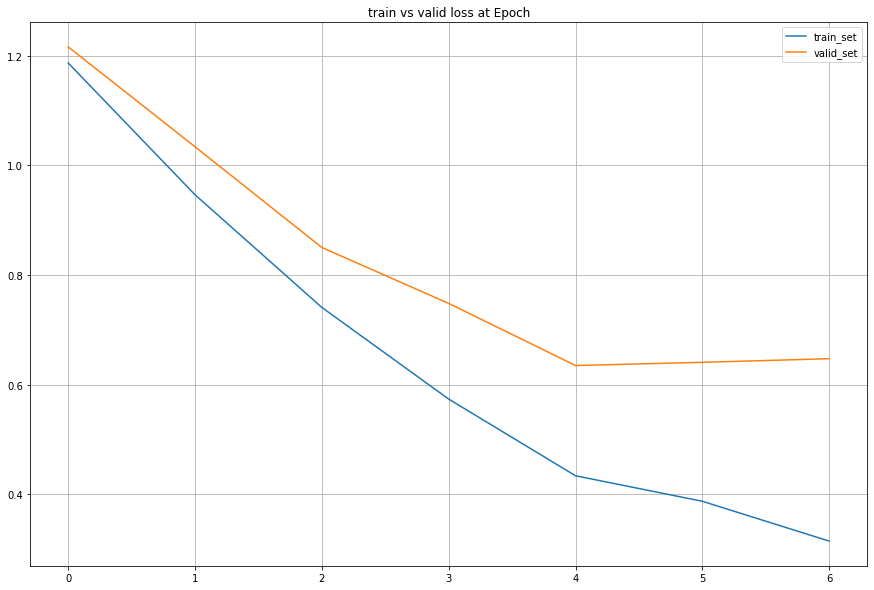

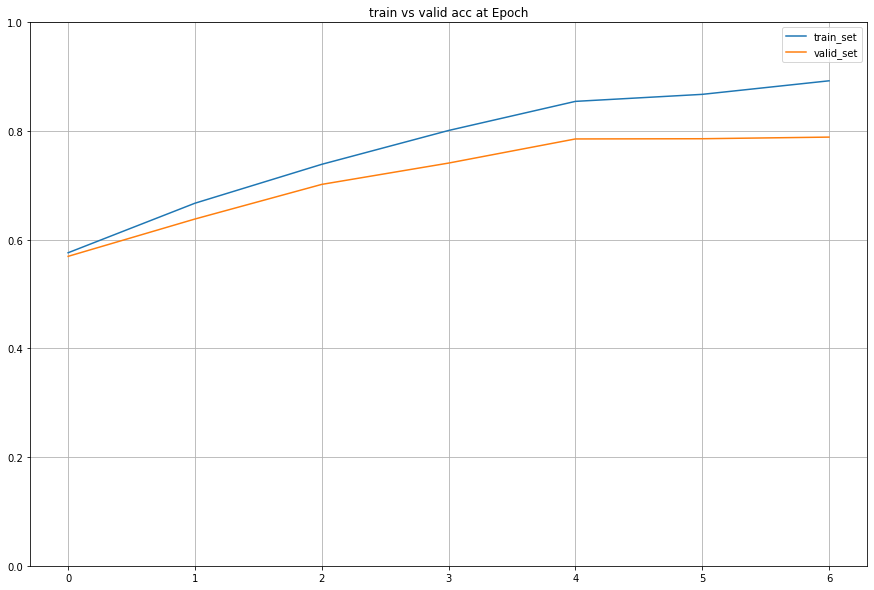

In [18]:
plot_compare(train_losses, valid_losses, title = "train vs valid loss at Epoch")

plot_compare(train_accs, valid_accs, [0, 1.0], title = "train vs valid acc at Epoch")